# Natural Language Processing and Application
#### Université Mohamed V, Faculté des Sciences de Rabat 
#### Pr. Abdelhak Mahmoudi
## Machine Translation Mini-Project


In this notebook, we are going to carry out our Natural Language Processing project on **machine translation**.
We are going to build a deep neural network using the **transform** "*Attention is all you need*" mecanism.
We will train a "Neural Machine Traslation" model which will receive a text from an original language (here in French) and translate it into another language (here in Portuguese).

- **Pre-processing**  Clean and convert text to sequence of integers.
- **Model** Create models which accepts a sequence of integers as input and returns a probability distribution over possible translations.
- **Prediction** Run the model to predict the translation corresponding to the original text.

# Loading the libraries

In [1]:
import os
import time
import re
from unicodedata import normalize
import string

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers

import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import sklearn
from sklearn.model_selection import train_test_split

### Verify the CPU

This python environment has been configured with intelpython oneAPI Deep Neural Network Library for CPU optimization.

In [2]:

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13509344257185359327
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17775901557357788850
physical_device_desc: "device: XLA_CPU device"
]


In [3]:
print(tf.__version__)


2.0.0


#### Setting some parameters and hyperparameters for our model

In [4]:
# Parameters for our model
INPUT_COLUMN = 'feature'
TARGET_COLUMN = 'target'
NUM_SAMPLES = 20000

BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 10  # Number of epochs to train for.


# Global parameters
DATA_PATH = './data_fr_por'
train_filename='fr_por.txt'
checkpoint_folder = 'checkpoint'
model_folder = 'model'

# Variable for data directory
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))
checkpoint_path = os.path.abspath(os.path.join(DATA_PATH, checkpoint_folder))
model_path = os.path.abspath(os.path.join(DATA_PATH, model_folder))


# The dataset and text processing


We start by studying the dataset that will be used to train and evaluate our model.
For this exercise, we will use sentence pairs, the source in French and the target in Portuguese, from the Tatoeba project where people help add translations from English to other languages.

Here we have collected around 50,000 sentences of our choice in French and translate them using google sheets.
This is the link [www.manythings.org/anki](http://www.manythings.org/anki/) to some translations from English to different languages.

However, it will take a long time to train the neural network with this number of sentences.
We will therefore use this reduced data set down to 20,000 to train the model within a somewhat reasonable time frame which will allow us to have at least some very acceptable predictions, because our model which will be built with the attention mechanism will take too much time to complete a single training epoch.

## Loading the dataset

The data can be found in `data_fr_por/fr_por.txt`.
The data will be loaded with a desired number of lines per pandas DataFrame and will be shuffled again.
Then we get the **input** and **target** columns in two variables to apply the preprocessing functions.

In [5]:
# Load the dataset: sentence input and sentence output 
data_file = pd.read_csv(train_filenamepath,
                        sep="\t",
                        header=None,
                        names=[INPUT_COLUMN, TARGET_COLUMN],
                        usecols=[0,1],
                        nrows=NUM_SAMPLES
                       )

print(data_file)
data_file = sklearn.utils.shuffle(data_file)  # shuffle the dataset

# Save the dataset selected as csv and txt file
data_file.to_csv(DATA_PATH+'/data_file.csv', header=None, index=False)
data_file.to_csv(DATA_PATH+'/data_file.txt', sep="\t", header=None, index=False)

# load the input and target data
input_data = data_file[INPUT_COLUMN].values
target_data = data_file[TARGET_COLUMN].values

print('\nNumber of sentences: ', len(input_data))
print(input_data[:5])
print(target_data[:5])


                                     feature  \
0                                       Va !   
1                                    Marche.   
2                                    Bouge !   
3                                    Salut !   
4                                     Salut.   
...                                      ...   
19995   Je pensais que ça pouvait être vous.   
19996            Nous allons être agressifs.   
19997  J'ignore encore ce que je vais faire.   
19998                        Tom est vivant.   
19999     Tom déteste se lever tôt le matin.   

                                     target  
0                                      Ir !  
1                                    Andar.  
2                                    Mover!  
3                                      Oi !  
4                                       Oi.  
...                                     ...  
19995       Eu pensei que poderia ser você.  
19996               Nós seremos agressivos.  
19997    

#### The following function will be used to apply data cleansing.


In [6]:
# clean a list of lines
def clean_preprocess_text(lines):
    clean_pair = list()
    for line in lines:
        # normalize unicode characters
        line = normalize('NFD', line).encode('ascii', 'ignore')
        line = line.decode('UTF-8')
        # convert to lowercase
        line = line.lower()
        # put space before and after punctuation
        line = re.sub(r"([?.!])", r" \1 ", line)
        # replace ' and - with a space
        line = re.sub(r"['-]", r" ", line)
        # remove digits
        remove_digits = str.maketrans('', '', string.digits)
        line = line.translate(remove_digits)
        # reduces spaces into one
        line = re.sub(r" +", r" ", line)
        # remove space at start and end of line
        line = line.strip()
        # add the cleaned line in a new table which will contain all the new sentences
        clean_pair.append(line)
        
    return np.array(clean_pair)


#### Apply cleansing on input and target data

In [7]:
# clean input and target data
input_data = clean_preprocess_text(input_data)
target_data = clean_preprocess_text(target_data)

# save the data cleaned with pandas DataFrame
data_cleaned = pd.DataFrame(columns=[INPUT_COLUMN, TARGET_COLUMN])
data_cleaned[INPUT_COLUMN] = input_data
data_cleaned[TARGET_COLUMN] = target_data

data_cleaned.to_csv(DATA_PATH + '/data_cleaned.csv', header=None, index=False)
data_cleaned.to_csv(DATA_PATH + '/data_cleaned.txt', sep="\t", header=None, index=False)

# Show some sentences cleaned
print(input_data[:5])
print(target_data[:5])

print(input_data[-5:])
print(target_data[-5:])


['je suis heureuse de vous avoir invitee .'
 'je ne suis pas encore tout a fait pret .'
 'berne est la capitale de la suisse .' 'soyez prudent !'
 'quand il est venu ici n est pas clair .']
['estou feliz por ter convidado voce .' 'eu nao estou bem pronto ainda .'
 'berna e a capital da suica .' 'tome cuidado !'
 'quando ele veio aqui nao e claro .']
['es tu levee ?'
 'les enfants dormaient lorsque leurs grands parents les appelerent .'
 'etes vous certaine que vous devez partir ?'
 'tout ce que tu as entendu est vrai .' 'tom est efficace .']
['voce esta levantando ?'
 'as criancas dormiam quando seus avos os chamavam .'
 'tem certeza de que tem que sair ?' 'tudo o que voce ouviu e verdade .'
 'tom e eficaz .']


- By looking at the sentences, you can see that they have already been preprocessed. The punctuations were delimited by spaces. All text has been converted to lowercase.

# Tokenize the text data

For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "cat" is a sequence of ASCII character encodings.  Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

Next, let's see how to prepare the data for our model. It's very simple and the steps are as follows:

- Create vocabulary from the corpus using the tokenization of words. The `create_tokenizer()` function creates the **tokenizer** using [**Keras**](https://keras.io/preprocessing/text/#tokenizer) to get the *token for each word* in the corpus, accepting some punctuation ('.!?').
- Calculate the maximum length of the input and output sequences. `max_length()` function
- Convert plain text to a sequence of integers. `encode_sequences()`
- Filling of sentences: you must fill in zeros at the end of the sequences so that all the sequences have the same length. Otherwise, we will not be able to train the model on batches

In [8]:
# fit a tokenizer
def create_tokenizer(lines):
    to_exclude = '"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n'
    to_tokenize = '.!?'
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=to_exclude)
    tokenizer.fit_on_texts(lines)
    return tokenizer


# max sentence length
def max_length(lines):
    # add 2 to max length because sos_token(start sent) and eos_token(end sent) will be added in the sentence
    return max(len(line.split()) for line in lines) + 2


# encode the corpus and add paddind to max length
def encode_sequences(corpus, tokenizer, max_length, sos_token, eos_token):
    # encode the corpus
    sentences = tokenizer.texts_to_sequences(corpus)

    # add START and END token to the corpus
    sentences = [sos_token + sentence + eos_token for sentence in sentences]

    # Pad the sentences
    sentences = tf.keras.preprocessing.sequence.pad_sequences(sentences,
                                                              value=0,
                                                              padding='post',
                                                              maxlen=max_length
                                                              )
    return sentences


In [9]:
# Tokenizer example
expl_sentences = [
    'this is a sentence',
    'the laws were very difficult to enforce .',
    'would you care to come ?'
]
tokenizer_expl = create_tokenizer(expl_sentences)
print(tokenizer_expl.word_index)

print()
for sample_i, (sent, token_sent) in enumerate(zip(expl_sentences, tokenizer_expl.texts_to_sequences(expl_sentences))):
    print('Sequence {}'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

print()
expl_max_length = max_length(expl_sentences)
sos_token_expl = [expl_max_length - 2]
eos_token_expl = [expl_max_length - 1]
expl_sentences_encoded = encode_sequences(expl_sentences, 
                                          tokenizer_expl, 
                                          expl_max_length, 
                                          sos_token_expl, 
                                          eos_token_expl
                                         )
print("After padding: ")
print("Max length: ", expl_max_length)
for sample_i, seq_pad in enumerate(expl_sentences_encoded):
    print('Sequence {}'.format(sample_i + 1))
    print('  Input:  {}'.format(seq_pad))
    

{'to': 1, 'this': 2, 'is': 3, 'a': 4, 'sentence': 5, 'the': 6, 'laws': 7, 'were': 8, 'very': 9, 'difficult': 10, 'enforce': 11, '.': 12, 'would': 13, 'you': 14, 'care': 15, 'come': 16, '?': 17}

Sequence 1
  Input:  this is a sentence
  Output: [2, 3, 4, 5]
Sequence 2
  Input:  the laws were very difficult to enforce .
  Output: [6, 7, 8, 9, 10, 1, 11, 12]
Sequence 3
  Input:  would you care to come ?
  Output: [13, 14, 15, 1, 16, 17]

After padding: 
Max length:  10
Sequence 1
  Input:  [8 2 3 4 5 9 0 0 0 0]
Sequence 2
  Input:  [ 8  6  7  8  9 10  1 11 12  9]
Sequence 3
  Input:  [ 8 13 14 15  1 16 17  9  0  0]


#### Tokenize and pad the input sequences

In [10]:
# prepare input tokenizer
tokenizer_inputs = create_tokenizer(input_data)
input_vocab_size = len(tokenizer_inputs.word_index) + 3  # (+3) to add start and end token, and the 0 index
input_max_length = max_length(input_data)
sos_token_input = [input_vocab_size - 2]
eos_token_input = [input_vocab_size - 1]

encoder_inputs = encode_sequences(input_data, tokenizer_inputs, input_max_length, sos_token_input, eos_token_input)

print('Input Vocabulary Size (unique words): %d' % input_vocab_size)
print('Input Max Length: %d' % (input_max_length))

print(encoder_inputs[:2])
print(encoder_inputs[-2:])

Input Vocabulary Size (unique words): 9164
Input Max Length: 63
[[9162    2   28  408    4    8  108 2075    1 9163    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [9162    2   13   28    7  125   46    3   47  368    1 9163    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]
[[9162   46   17    9   14   49  276    6  326    1 9163    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 

#### Tokenize and pad the outputs sequences

In [11]:
# prepare output tokenizer
tokenizer_outputs = create_tokenizer(target_data)
output_vocab_size = len(tokenizer_outputs.word_index) + 3  # (+3) to add start and end token, and the 0 index
output_max_length = max_length(target_data)
sos_token_output = [output_vocab_size - 2]
eos_token_output = [output_vocab_size - 1]
    
decoder_outputs = encode_sequences(target_data, tokenizer_outputs, output_max_length, sos_token_output, eos_token_output)

print('Output Vocabulary Size (unique words): %d' % output_vocab_size)
print('Output Max Length: %d' % (output_max_length))

print(decoder_outputs[:2])
print(decoder_outputs[-2:])

Output Vocabulary Size (unique words): 8552
Output Max Length: 52
[[8550   39   99   23   72  516    3    1 8551    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [8550    2    5   39   88  224   97    1 8551    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]]
[[8550   66    9    4    3  469    7  160    1 8551    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [8550   11    7 2616    1 8551    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0   

### Creating training and validation dataset using *sklearn*
split 80% training and 20% validation

In [13]:
encoder_inputs, encoder_inputs_valid, decoder_outputs, decoder_outputs_valid = train_test_split(encoder_inputs, decoder_outputs, test_size=0.2)


# Models

In this section, we will experiment with different neural network architectures.
We will begin by training one relatively simple architecture.

- Model 1 : an Encoder-Decoder RNN

After experimenting with this simple architecture, we will build a deeper architecture designed to surpass this model. Because this RNN architecture has a great limitation when working with long sequences, their ability to retain information from the first elements will be lost when new elements are incorporated into the sequence.

- Model 2 : a Transformer, encoder-decoder with Attention

The **Transformer**, a model architecture eschewing recurrence and instead relying entirely on an attention mechanism to draw global dependencies between input and output. The Transformer allows for significantly more parallelization … the Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence-aligned RNNs or convolution.

#### We define the functions that will be used for the prediction of model 1

In [17]:
# map an integer to a word
def word_for_id_RNN(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


# predict text target
def predict_sequence_RNN(sequences, tokenizer):
    target = list()
    for i in sequences:
        word = word_for_id_RNN(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)


# This function selects the lines whose length does not exceed the given limit.
# This function will be used for the RNN model to choose only short sentences.
# The transformer model will work with the maximum sentence length without limit.
LIMITE = 12
N_ROWS = 10000
# eos_token (max in sequence) allows to detect the end of sentence
def limit_seq_len(sequences, limite, n_rows, eos_token):
    out = list()
    tab_index = list()
    j = 0
    for i in range(n_rows):
        while np.argmax(sequences[j]) >= limite and j < len(sequences):
            j += 1
        seq = sequences[j][:limite+1]
        seq = np.delete(seq, [0])  # delete sos_token
        seq[seq==eos_token] = 0    # delete eos_token
        out.append(seq)
        tab_index.append(j)
        j += 1
    return np.array(out), tab_index


X_train, x_index = limit_seq_len(encoder_inputs, LIMITE, N_ROWS, eos_token_input)

# get the Y targets corresponding to the X inputs using the indexes of X
Y_train = np.array([np.delete(y, [0]) for y in decoder_outputs[x_index][:, :LIMITE+1]])
Y_train[Y_train==eos_token_output] = 0

print(predict_sequence_RNN(X_train[0], tokenizer_inputs))
print(predict_sequence_RNN(Y_train[0], tokenizer_outputs))

Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)

# We select a few sentences not to train to predict their translation
X_eval, _ = limit_seq_len(encoder_inputs_valid, LIMITE, 5, eos_token_input)

print(X_train.shape)
print(Y_train.shape)
print(X_eval.shape)
print(X_train[:3])
print(Y_train[:3])


ou puis je acheter une chemise comme ca ?
onde posso comprar uma camisa assim ?
(10000, 12)
(10000, 12, 1)
(5, 12)
[[  69  177    2  277   26  991  105   35    5    0    0    0]
 [  17   19   48   34   26 7976    1    0    0    0    0    0]
 [ 303   14 1155    3   50 9090    3   87  449    5    0    0]]
[[[  69]
  [  47]
  [ 272]
  [  19]
  [ 970]
  [ 212]
  [   6]
  [   0]
  [   0]
  [   0]
  [   0]
  [   0]]

 [[  38]
  [ 126]
  [  13]
  [4404]
  [   1]
  [   0]
  [   0]
  [   0]
  [   0]
  [   0]
  [   0]
  [   0]]

 [[   3]
  [ 154]
  [   4]
  [  21]
  [  68]
  [1129]
  [  20]
  [  29]
  [ 493]
  [   6]
  [   0]
  [   0]]]


### Model 1: Encoder-Decoder RNN

Now let's look at the encoder-decoder models.  This model is composed of an encoder and decoder. The encoder creates a matrix representation of the sentence.  The decoder takes this matrix as input and predicts the translation as output.

![enc_dec_rnn.png](images/enc_dec_rnn.png)

#### Encoder
- A stack of several recurrent units (LSTM or GRU cells for better performance) where each accepts a single element of the input sequence, collects information for that element and propagates it forward.

#### Encoder Vector
- This is the final hidden state produced from the encoder part of the model.

#### Decoder
- A stack of several recurrent units where each predicts an output y_t at a time step t.
- Each recurrent unit accepts a hidden state from the previous unit and produces and output as well as its own hidden state.

Let's create an encoder-decoder model in the cell below.

In [18]:
# define NMT model
def Encoder_decoder_model_RNN(src_vocab, tar_vocab, src_length, tar_length, n_units):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(src_vocab, n_units, input_length=src_length, mask_zero=True))
    model.add(keras.layers.LSTM(n_units))
    model.add(keras.layers.RepeatVector(tar_length))
    model.add(keras.layers.LSTM(n_units, return_sequences=True))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(tar_vocab, activation='softmax')))
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam')
    return model
    

# Train the neural network
enc_dec_rnn_model = Encoder_decoder_model_RNN(input_vocab_size, 
                                              output_vocab_size, 
                                              LIMITE, 
                                              LIMITE,
                                              256
                                             )
enc_dec_rnn_model.summary()
print()

enc_dec_rnn_model.fit(X_train, 
                      Y_train, 
                      batch_size=64, 
                      epochs=40
                     )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 12, 256)           2345984   
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 12, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 12, 256)           525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 8552)          2197864   
Total params: 5,594,472
Trainable params: 5,594,472
Non-trainable params: 0
_________________________________________________________________

Train on 10000 samples
Epoch 1/40
10000/10000 [==============================] - 98s 10ms/sample - loss: 3.93

##### Make prediction for RNN model

In [19]:
# Make prediction
for seq_input in X_eval:
    seq_input = seq_input.reshape(1, seq_input.shape[0])
    #print(seq_input, " --- ", seq_input.shape)
    
    # predict
    prediction = enc_dec_rnn_model.predict(seq_input, verbose=0)[0]
    #print("prediction: ", prediction)
    seq_predicted = tf.squeeze([tf.cast(tf.argmax(vector), tf.int32) for vector in prediction])
    #print("seq_predicted: ", seq_predicted)
    
    seq_input_text = predict_sequence_RNN(tf.squeeze((seq_input)), tokenizer_inputs)
    print("in : ", seq_input_text)
    prediction_text = predict_sequence_RNN(seq_predicted, tokenizer_outputs)
    print("out : ", prediction_text)
    print()

in :  nous etions des ennemis .
out :  nos estavamos todos .

in :  tom a ete embarrasse .
out :  tom foi marie .

in :  ce n est pas la fin de l histoire .
out :  nao e e no problema .

in :  j ai essaye .
out :  eu tentei .

in :  laisse moi t aider !
out :  me deixar ir !



# Model 2: Transformer

## Attention is all you need: Discovering the Transformer model

### Neural machine traslation using a Transformer model

This paper was a more advanced step in the use of the attention mechanism being the main basis for a model called Transformer.

Attention is all you need: https://arxiv.org/pdf/1706.03762.pdf

We will describe the components of this model, analyze their operation and build a simple model that we will apply to our Machine Translation problem.

![transformer.png](images/transformer.png)

## Why we need Transformer?

In sequence-to-sequence treatment problems such as the neural machine translation, the initial proposals were based on the use of RNNs in an encoder-decoder architecture. These architectures presented a great limitation when working with long sequences, their ability to retain information from the first elements was lost when new elements were incorporated into the sequence. In the encoder, the hidden state in every step is associated with a certain word in the input sentence, the more recent. Therefore, if the decoder only accesses the last hidden state of the decoder, it will lose relevant information about the first elements of the sequence. Then to deal with this limitation, a new concept were introduced **the attention mechanism**.

Instead of paying attention to the last state of the encoder as is usually done with the RNNs, in each step of the decoder we look at all the states of the encoder, being able to access information about all the elements of the input sequence. This is what attention does, it extracts information from the whole sequence, a weighted sum of all the past encoder states. This allows the decoder to assign greater weight or importance to a certain element of the input for each element of the output. Learning in every step to focus in the right element of the input to predict the next output element.

But this approach continues to have an important limitation, each sequence must be treated one at a time. Both the encoder and the decoder have to wait till the completion of t-1 steps to process at 't'th step. So when dealing with huge corpus **it is very time consuming and computationally inefficient**.

# Create the batch data generator

- Create a batch data generator: we want to train the model on batches, group of sentences, so we need to create a Dataset using the tf.data library and the function batch_on_slices on the input and output sequences.

In [20]:
# Define a dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs, decoder_outputs))
train_dataset = train_dataset.shuffle(len(encoder_inputs), reshuffle_each_iteration=True).batch(
    BATCH_SIZE, drop_remainder=True)

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [21]:
# Define a dataset for validation
valid_dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs_valid, decoder_outputs_valid))
valid_dataset = valid_dataset.shuffle(len(encoder_inputs_valid), reshuffle_each_iteration=True).batch(
    BATCH_SIZE, drop_remainder=True)

valid_dataset = valid_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Building a Transformer

## What is Transformer?
*In this work we propose the Transformer, a model architecture eschewing recurrence and instead relying entirely on an attention mechanism to draw global dependencies between input and output. The Transformer allows for significantly more parallelization … the Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence-aligned RNNs or convolution.*

"Attention is all you need" paper

The Transformer model extract  features for each word using a self-attention mechanism to figure out how important all the other words in the sentence are w.r.t. to the aforementioned word. And no recurrent units are used to obtain this features, they are just weighted sum and activations, so they can be very parallelizable and efficient.

But We will dive deeper to understand what all this means.

# Self-attention: the fundamental operation

*Self-attention is a sequence-to-sequence operation: a sequence of vectors goes in, and a sequence of vectors comes out. Let's call the input vectors 𝐱1,𝐱2,…𝐱t and the corresponding output vectors 𝐲1,𝐲2,…,𝐲t. The vectors all have dimension k. To produce output vector 𝐲i, the self attention operation simply takes a weighted average over all the input vectors, the simplest option is the dot product.*

**Transformers from scratch by Peter Bloem**

In the self-attention mechanism of our model we need to introduce three elements: **Queries**, **Values** and **Keys**


## Queries, Keys and Values
Every input vector is used in three different ways in the self-attention mechanism: the Query, the Key and the Value. In every role, it is compared to the others vectors to get its own output yi (Query), to get the j-th output yj (Key) and to compute each output vector once the weights have been established (Value).

To obtain this roles, we need three weight matrices of dimensions k x k and compute three linear transformation for each xi:

![query_key_value.png](images/query_key_value.png)
![K_Q_V.png](images/K_Q_V.png)

These three matrices are usually known as K, Q and V, three learnable weight layers that are applied to the same encoded input. Consequently, as each of these three matrices come from the same input, we can apply the attention mechanism of the input vector with itself, a "self-attention".


## Scale dot-product Attention

*The input consists of queries and keys of dimension dk, and values of dimension dv. We compute the dot products of the query with all keys, divide each by the square root of dk, and apply a softmax function to obtain the weights on the values.*

"Attention is all you need" paper

Then we use the Q, K and V matrices to calculate the attention scores. **The scores measure how much focus to place on other places or words of the input sequence w.r.t a word at a certain position**. That is, the dot product of the query vector with the key vector of the respective word we're scoring. So, for position 1 we calculate the dot product (.) of q1 and k1, then q1 . k2, q1 . k3,… 

Next we apply the "scaled" factor to have more stable gradients. The softmax function can not work properly with large values, resulting in vanishing the gradient and slow down the learning. After "softmaxing" we multiply by the Value matrix to keep the values of the words we want to focus on and minimizing or removing the values for the irrelevant words (its value in V matrix should be very small).

The formula for these operations is:

$Attention(Q, K, V ) = \text{softmax}\left(\dfrac{QK^T}{\sqrt{d_k}}\right)V $


In [22]:
def scaled_dot_product_attention(queries, keys, values, mask):
    # Calculate the dot product, QK_transpose
    product = tf.matmul(queries, keys, transpose_b=True)
    # Get the scale factor
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    # Apply the scale factor to the dot product
    scaled_product = product / tf.math.sqrt(keys_dim)
    # Apply masking when it is requiered
    if mask is not None:
        scaled_product += (mask * -1e9)
    # dot product with Values
    attention = tf.matmul(tf.nn.softmax(scaled_product, axis=-1), values)
    
    return attention

## Multi-Head Attention

In the previous description the attention scores are focused on the whole sentence at a time, this would produce the same results even if two sentences contain the same words in a different order. Instead, we would like to attend to different segments of the words. We can give the self attention greater power of discrimination, **by combining several self attention heads**, dividing the words vectors into a fixed number (h, number of heads) of chunks, and then self-attention is applied on the corresponding chunks, using Q, K and V sub-matrices. 

This produce h different output matrices of scores.


![Scaled_Dot_Product_Attention.png](images/dot_product_multihead.png)


But the next layer (the Feed-Forward layer) is expecting just one matrix, a vector for each word, so after calculating the dot product of every head, we concat the output matrices and multiply them by an additional weights matrix $W_O$. This final matrix captures information from all the attention heads.

$MultihHead(Q, K, V ) = \text{Concat}(head_1,...,head_n)W^O$

where $head_i=Attention(QW_i^Q,QW_i^K,QW_i^V)$ and $i$ is the head index.


In [23]:
class MultiHeadAttention(layers.Layer):
    
    def __init__(self, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.n_heads == 0
        # Calculate the dimension of every head or projection
        self.d_head = self.d_model // self.n_heads
        # Set the weight matrices for Q, K and V
        self.query_lin = layers.Dense(units=self.d_model)
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)
        # Set the weight matrix for the output of the multi-head attention W0
        self.final_lin = layers.Dense(units=self.d_model)
        
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)
        # Set the dimension of the projections
        shape = (batch_size,
                 -1,
                 self.n_heads,
                 self.d_head)
        # Split the input vectors
        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)
    
    def call(self, queries, keys, values, mask):
        # Get the batch size
        batch_size = tf.shape(queries)[0]
        # Set the Query, Key and Value matrices
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)
        # Split Q, K y V between the heads or projections
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)
        # Apply the scaled dot product
        attention = scaled_dot_product_attention(queries, keys, values, mask)
        # Get the attention scores
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        # Concat the h heads or projections
        concat_attention = tf.reshape(attention,
                                      shape=(batch_size, -1, self.d_model))
        # Apply W0 to get the output of the multi-head attention
        outputs = self.final_lin(concat_attention)
        
        return outputs

# Positional Encoding

We mentioned briefly that the order of the words in the sentence is an issue to solve in this model, because the network and the self-attention mechanism is permutation invariant. If we shuffle up the words in the input sentence, we get the same solutions. We need to create a representation of the position of the word in the sentence and add it to the word embedding.

*To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension as the embeddings, so that the two can be summed. There are many choices of positional encodings.*

"Attention is all you need" paper

![pos_encoding.png](images/pos_encoding.png)

So, we apply a function to map the position in the sentence to real valued vector. The network will learn how to use this information. Another approach would be to use a position embedding, similar to word embedding, coding every known position with a vector. It would requiere sentences of all accepted positions during training but positional encoding allow the model to extrapolate to sequence lengths longer than the ones encountered.

In the paper a sinusoidal function is applied:

$PE_{(pos,2i)} =\sin(pos/10000^{2i/dmodel})$

$PE_{(pos,2i+1)} =\cos(pos/10000^{2i/dmodel})$

In [24]:
class PositionalEncoding(layers.Layer):

    def __init__(self):
        super(PositionalEncoding, self).__init__()
    
    def get_angles(self, pos, i, d_model): # pos: (seq_length, 1) i: (1, d_model)
        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
        return pos * angles # (seq_length, d_model)

    def call(self, inputs):
        # input shape batch_size, seq_length, d_model
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        # Calculate the angles given the input
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
        # Calculate the positional encodings
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        # Expand the encodings with a new dimension
        pos_encoding = angles[np.newaxis, ...]
        
        return inputs + tf.cast(pos_encoding, tf.float32)

# The Encoder

Now that all the main pieces of the model have been described we can introduce the encoder components. 

- Positional encoding: Add the position encoding to the input embedding (our input words are transformed to embedding vectors). *The same weight matrix is shared between the two embedding layers (encoder and decoder) and the pre-softmax linear transformation. In the embedding layers, we multiply those weights by square root of the model dimension* [1], ${\sqrt{d_{model}}}$.

- N = 6, identical layers, containing two sub-layers: a **multi-head self-attention mechanism**, and a **fully connected feed-forward network**. This FC layer is applied to each position separately and identically and consists of two linear transformations with a ReLU activation in between. But it is applied position-wise to the input, which means that the same neural network is applied to every single "token" vector belonging to the sentence sequence.

$$FFN(x)= max(0,xW_1+b_1)W_2+b_2$$

- There is a residual connection around each sub-layer (attention and FC network) followed by a layer normalization.

*Normalization and residual connections are standard tricks used to help deep neural networks train faster and more accurately. The layer normalization is applied over the embedding dimension only.*

**Peter Bloem, "Transformers from scratch"**

The next figure will show the components detailed:

![encoder.PNG](images/encoder.png)

Keep in mind that **only the vector from the last layer (6-th) is sent to the decoder**.

In [25]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(EncoderLayer, self).__init__()
        # Hidden units of the feed forward component
        self.FFN_units = FFN_units
        # Set the number of projectios or heads
        self.n_heads = n_heads
        # Dropout rate
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        # Build the multihead layer
        self.multi_head_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        # Layer Normalization
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        # Fully connected feed forward layer
        self.ffn1_relu = layers.Dense(units=self.FFN_units, activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        # Layer normalization
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training):
        # Forward pass of the multi-head attention
        attention = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        attention = self.dropout_1(attention, training=training)
        # Call to the residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call to the FC layer
        outputs = self.ffn1_relu(attention)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        # Call to residual connection and the layer normalization
        outputs = self.norm_2(outputs + attention)
        
        return outputs

In [26]:
class Encoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        # The embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stack of n layers of multi-head attention and FC
        self.enc_layers = [EncoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    def call(self, inputs, mask, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale the embeddings by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training)

        return outputs

# The Decoder

The decoder share some components with the encoder but they are used in a different way to take into account the encoder output.

- Positional encoding: Similar that the one in the encoder
- N=6 identical layers, containing 3 three sublayers. First, the Masked Multi-head attention or **masked causal attention** to prevent positions from attending to subsequent positions, hiding those features that belong to future states of the sequence. "This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than i" [1]. It is implemented setting to −∞ the values corresponding to the forbidden states in the softmax layer of the dot-product attention modules. The second component or **"encoder-decoder attention"** performs multi-head attention over the output of the decoder, the Key and Value vectors come from the output of the encoder but the queries come from the previous decoder layer. *This allows every position in the decoder to attend over all positions in the input sequence* [1]. And finally the fully-connected network.

- The residual connection and layer normalization around each sub-layer, similar to the encoder.

![decoder.png](images/decoder.png)

At the end of the N stacked decoders, the **linear layer**, a fully-connected network, transforms the stacked outputs to a much larger vector, the *logits*. The **softmax layer** then turns those scores (logits) into probabilities (all positive, all add up to 1.0). The cell with the highest probability is chosen, and the word associated with it is produced as the output for this time step.

In [27]:
class DecoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        
        # Self multi head attention, causal attention
        self.multi_head_causal_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        # Multi head attention, encoder-decoder attention 
        self.multi_head_enc_dec_attention = MultiHeadAttention(self.n_heads)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Feed foward
        self.ffn1_relu = layers.Dense(units=self.FFN_units,
                                    activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_3 = layers.Dropout(rate=self.dropout_rate)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        # Call the masked causal attention
        attention = self.multi_head_causal_attention(inputs,
                                                inputs,
                                                inputs,
                                                mask_1)
        attention = self.dropout_1(attention, training)
        # Residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call the encoder-decoder attention
        attention_2 = self.multi_head_enc_dec_attention(attention,
                                                  enc_outputs,
                                                  enc_outputs,
                                                  mask_2)
        attention_2 = self.dropout_2(attention_2, training)
        # Residual connection and layer normalization
        attention_2 = self.norm_2(attention_2 + attention)
        # Call the Feed forward
        outputs = self.ffn1_relu(attention_2)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_3(outputs, training)
        # Residual connection and layer normalization
        outputs = self.norm_3(outputs + attention_2)
        
        return outputs

In [28]:
class Decoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="decoder"):
        super(Decoder, self).__init__(name=name)
        self.d_model = d_model
        self.n_layers = n_layers
        # Embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        # Positional encoding layer
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stacked layers of multi-head attention and feed forward
        self.dec_layers = [DecoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encodding
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.dec_layers[i](outputs,
                                         enc_outputs,
                                         mask_1,
                                         mask_2,
                                         training)

        return outputs

# Transformer model

Once we have defined our components and created the encoder, the decoder and the linear-softmax final layer, we join the pieces to form our model, the Transformer.

![transformer_architecture.PNG](images/transformer_architecture.png)

In [29]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                 vocab_size_enc,
                 vocab_size_dec,
                 d_model,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)

        # Build the encoder
        self.encoder = Encoder(n_layers,
                               FFN_units,
                               n_heads,
                               dropout_rate,
                               vocab_size_enc,
                               d_model)
        # Build the decoder
        self.decoder = Decoder(n_layers,
                               FFN_units,
                               n_heads,
                               dropout_rate,
                               vocab_size_dec,
                               d_model)
        # build the linear transformation and softmax function
        self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")
    
    def create_padding_mask(self, seq): #seq: (batch_size, seq_length)
        # Create the mask for padding
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, seq):
        # Create the mask for the causal attention
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return look_ahead_mask
    
    def call(self, enc_inputs, dec_inputs, training):
        # Create the padding mask for the encoder
        enc_mask = self.create_padding_mask(enc_inputs)
        # Create the mask for the causal attention
        dec_mask_1 = tf.maximum(
            self.create_padding_mask(dec_inputs),
            self.create_look_ahead_mask(dec_inputs)
        )
        # Create the mask for the encoder-decoder attention
        dec_mask_2 = self.create_padding_mask(enc_inputs)
        # Call the encoder
        enc_outputs = self.encoder(enc_inputs, enc_mask, training)
        # Call the decoder
        dec_outputs = self.decoder(dec_inputs,
                                   enc_outputs,
                                   dec_mask_1,
                                   dec_mask_2,
                                   training)
        # Call the Linear and Softmax functions
        outputs = self.last_linear(dec_outputs)

        return outputs

It is worth mentioning that we create 3 masks, each of which will allow us:
- *Encoder mask*: It is a padding mask to discard the pad tokens from the attention calculation.
- *Decoder mask 1*: this mask is a union of the padding mask and the look ahead mask which will help the causal attention to discard the tokens "in the future". We take the maximum value between the padding mask and the look ahead one.
- *Decoder mask 2*: it is the padding mask and is applied in the encoder-decoder attention layer.

As you can see then we call the encoder, the decoder and the final linear-softmax layer to get the predicted output from our Transformer model.

# Training the Transformer model

Now that we have described in detail the components in the paper we are ready to implement them and train a transformer model on a NMT problem. It is a toy problem for educational purposes.

We need to create a custom loss function to mask the padding tokens and we define the Adam optimizer described in the paper, with beta1 = 0.9, beta2 = 0.98 and epsilon= 10e-9. And then we create a scheduler to vary the learning rate over the training process according to:

$lrate = d_{model}^{-0.5}*min(step\_num^{-0.5}, step\_num*warmup\_steps^{-1.5})$

In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


def loss_function(target, pred):
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = loss_object(target, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

And that's all, we have all the necessary elements to train our model using an usual loop for sequence-to-sequence tasks:
- For every iteration on the batch generator that produce batch size inputs and outputs
- Get the input sequence from 0 to length-1 and the actual outputs from 1 to length, the next word expected at every sequence step.
- Call the transformer to get the predictions
- Calculate the loss function between the real outputs and the predictions
- Apply the gradients to update the weights in the model
- Calculate the mean loss and the accuracy for the batch data
- Show some results and save the model in every epoch

Definition of training step `train_step` and validation step `valid_step` functions which will be called in the training of the model in the `main_train()` function

In [31]:
def train_step(enc_inputs, dec_inputs, dec_outputs_real):
    with tf.GradientTape() as tape:
        # Call the transformer and get the predicted output
        predictions = transformer(enc_inputs, dec_inputs, True)
        # Calculate the loss
        loss = loss_function(dec_outputs_real, predictions)
    # Update the weights and optimizer
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    # Save and store the metrics
    train_loss(loss)
    train_accuracy(dec_outputs_real, predictions)


def valid_step(enc_inputs, dec_inputs, dec_outputs_real):
    # Call the transformer and get the predicted output
    predictions = transformer(enc_inputs, dec_inputs, True)
    t_loss = loss_function(dec_outputs_real, predictions)
    # Set the metrics for the test
    valid_loss(t_loss)
    valid_accuracy(dec_outputs_real, predictions)

In [32]:
def main_train(train_dataset, valid_dataset, transformer, n_epochs, print_every=50):
  ''' Train the transformer model for n_epochs using the data generator dataset '''
  losses = []
  accuracies = []
  losses_valid = []
  accuracies_valid = []
  start_train = time.time()
  # In every epoch
  for epoch in range(n_epochs):
    print("Starting epoch {}".format(epoch+1))
    start = time.time()
    # Reset the losss and accuracy calculations
    train_loss.reset_states()
    train_accuracy.reset_states()
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    # Get a batch of inputs and targets
    for (batch, (enc_inputs, targets)) in enumerate(train_dataset):
        # Set the decoder inputs
        dec_inputs = targets[:, :-1]
        # Set the target outputs, right shifted
        dec_outputs_real = targets[:, 1:]
        # call of the training function
        train_step(enc_inputs, dec_inputs, dec_outputs_real)
                
        if batch % print_every == 0:
            losses.append(train_loss.result())
            accuracies.append(train_accuracy.result())
            print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(
                epoch+1, batch, train_loss.result(), train_accuracy.result()))
    
    # Checkpoint the model on every epoch        
    ckpt_save_path = ckpt_manager.save()
    print("Saving checkpoint for epoch {} in {}".format(epoch+1, ckpt_save_path))
    
    for (batch, (enc_inputs, targets)) in enumerate(valid_dataset):
        # Set the decoder inputs
        dec_inputs = targets[:, :-1]
        # Set the target outputs, right shifted
        dec_outputs_real = targets[:, 1:]
        # call of the validation function
        valid_step(enc_inputs, dec_inputs, dec_outputs_real)

        losses_valid.append(valid_loss.result())
        accuracies_valid.append(valid_accuracy.result())
        
    print("Epoch {}, Validation Loss {:.4f}, Validation Accuracy {:.4f}".format(
        epoch+1, valid_loss.result(), valid_accuracy.result()))
            
    print("Time for this epoch: {} secs\n".format(time.time() - start))
  
  train_time = time.time() - start_train
  s = int(train_time % 60)
  m = int(train_time // 60) % 60
  h = int(train_time // 60) // 60
  print("Total training time :  {}:{}:{}".format(h, m, s))

  return losses, accuracies, losses_valid, accuracies_valid

Setting the hyperparameters and parameters of the model and training process:

In [33]:
# Set hyperparamters for the model
D_MODEL = 512
N_LAYERS = 4
FFN_UNITS = 512
N_HEADS = 8
DROPOUT_RATE = 0.1

Now we define and create all the elements to train the model and evaluate it.

In [34]:
# Clean the session
tf.keras.backend.clear_session()
# Create the Transformer model
transformer = Transformer(vocab_size_enc=input_vocab_size,
                          vocab_size_dec=output_vocab_size,
                          d_model=D_MODEL,
                          n_layers=N_LAYERS,
                          FFN_units=FFN_UNITS,
                          n_heads=N_HEADS,
                          dropout_rate=DROPOUT_RATE
                         )

# Define a categorical cross entropy loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")

# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
# Define a matric to save the accuracy in every epoch
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

# Create the scheduler for learning rate decay
leaning_rate = CustomSchedule(D_MODEL)
# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9
                                    )
        

It is very useful to checkpoint and save our model during training. Training can take a lot of time and we can restore the model for future training or use.

In [37]:
# Create the Checkpoint 
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Last checkpoint restored.")

#### Model training

In [38]:
# Train the model
losses, accuracies, losses_valid, accuracies_valid = main_train(train_dataset,
                                                                valid_dataset,
                                                                transformer,
                                                                EPOCHS,
                                                                30
                                                               )

Starting epoch 1
Epoch 1 Batch 0 Loss 1.2951 Accuracy 0.0012
Epoch 1 Batch 30 Loss 1.2840 Accuracy 0.0133
Epoch 1 Batch 60 Loss 1.2540 Accuracy 0.0164
Epoch 1 Batch 90 Loss 1.2132 Accuracy 0.0174
Epoch 1 Batch 120 Loss 1.1814 Accuracy 0.0180
Epoch 1 Batch 150 Loss 1.1507 Accuracy 0.0188
Epoch 1 Batch 180 Loss 1.1153 Accuracy 0.0220
Saving checkpoint for epoch 1 in /Users/milkzo/Documents/Jupyter/mini_projet/data_fr_por/checkpoint/ckpt-1
Epoch 1, Validation Loss 0.8737, Validation Accuracy 0.0428
Time for this epoch: 1946.7228701114655 secs

Starting epoch 2
Epoch 2 Batch 0 Loss 0.8550 Accuracy 0.0441
Epoch 2 Batch 30 Loss 0.8309 Accuracy 0.0438
Epoch 2 Batch 60 Loss 0.8024 Accuracy 0.0444
Epoch 2 Batch 90 Loss 0.7881 Accuracy 0.0459
Epoch 2 Batch 120 Loss 0.7712 Accuracy 0.0473
Epoch 2 Batch 150 Loss 0.7567 Accuracy 0.0484
Epoch 2 Batch 180 Loss 0.7480 Accuracy 0.0496
Saving checkpoint for epoch 2 in /Users/milkzo/Documents/Jupyter/mini_projet/data_fr_por/checkpoint/ckpt-2
Epoch 2, Val

## Show some results from training


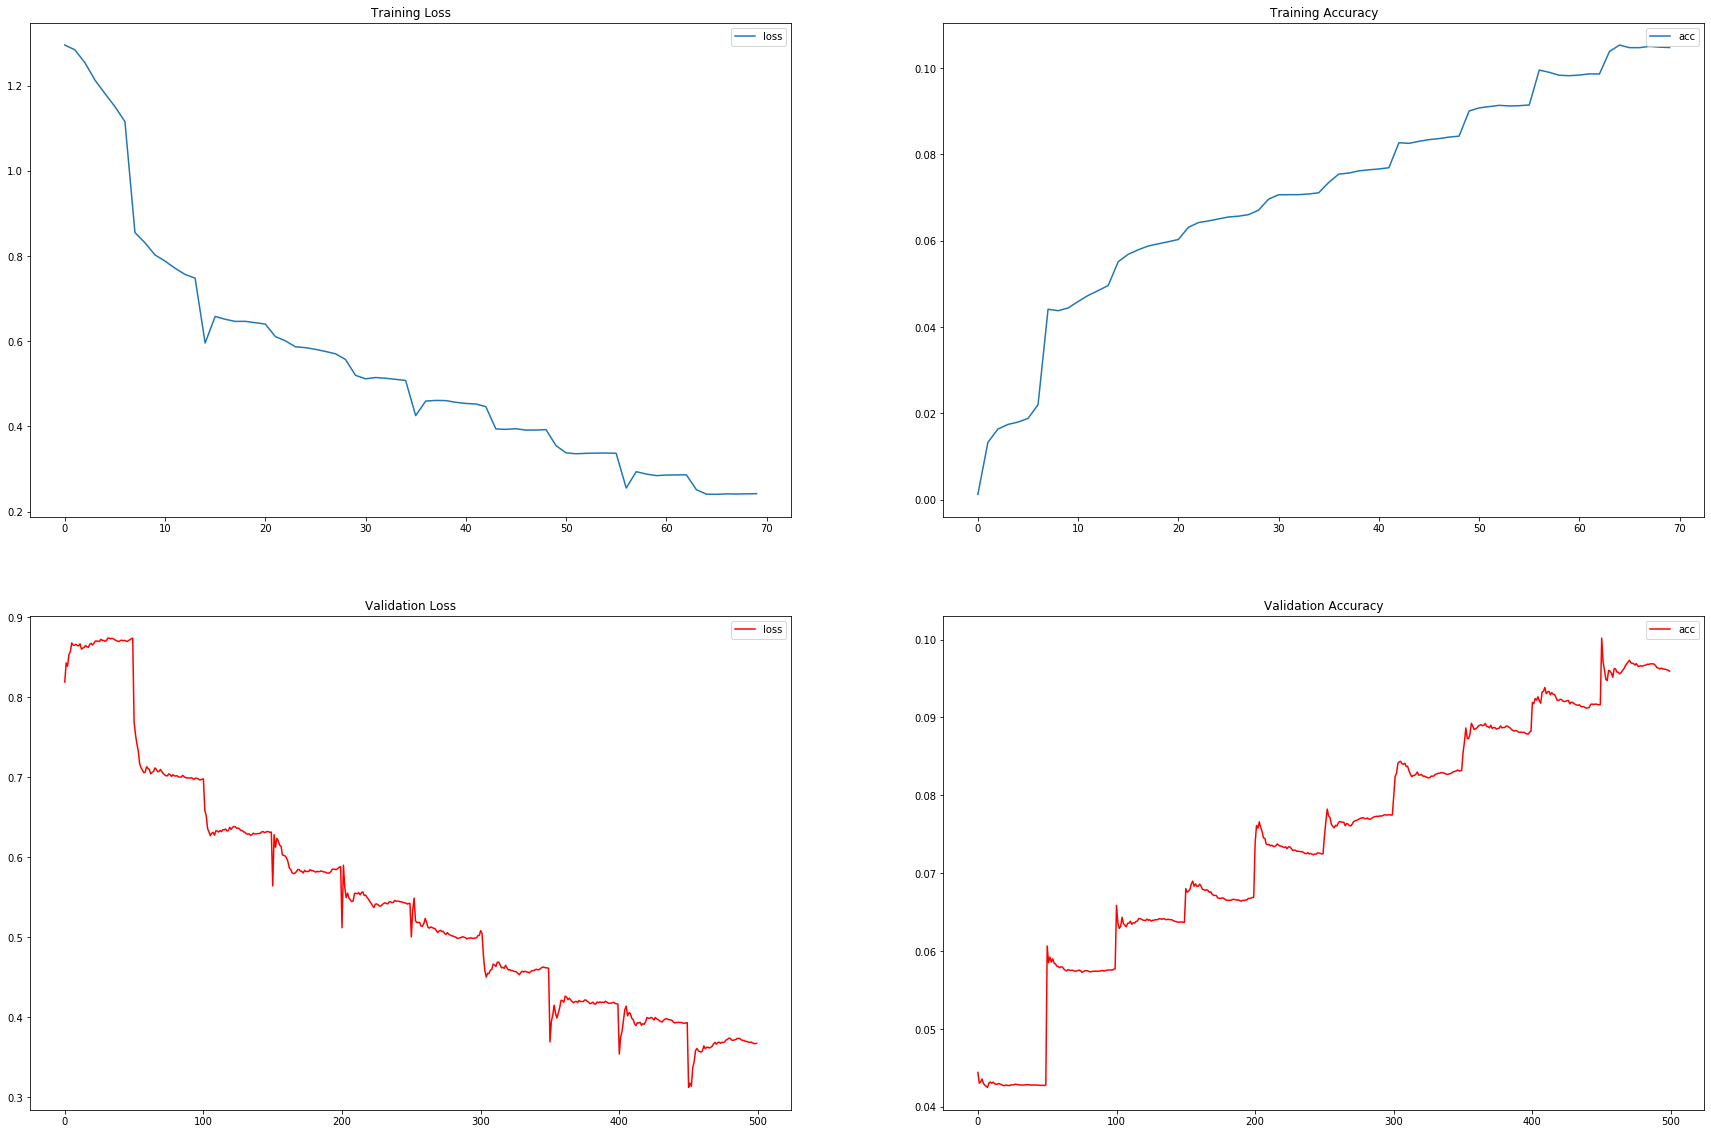

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(30, 20))
# Training Loss
ax[0][0].plot(losses, label='loss')
ax[0][0].set_title('Training Loss')
ax[0][0].legend()

# Training accuracies
ax[0][1].plot(accuracies, label='acc')
ax[0][1].set_title('Training Accuracy')
ax[0][1].legend()

# Validation loss
ax[1][0].plot(losses_valid, label='loss', c='r')
ax[1][0].set_title('Validation Loss')
ax[1][0].legend()

# Validation accuracies
ax[1][1].plot(accuracies_valid, label='acc', c='r')
ax[1][1].set_title('Validation Accuracy')
ax[1][1].legend()

plt.show()


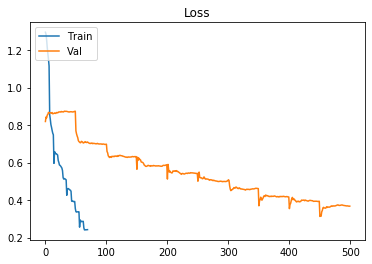

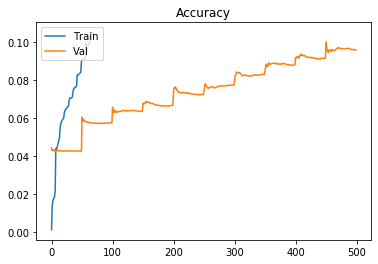

In [40]:
plt.plot(losses, label="Train")
plt.plot(losses_valid, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(accuracies, label="Train")
plt.plot(accuracies_valid, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

### Save the whole model

In [41]:
# Save the model as tensorflow format
print('Saving the model ....')
transformer.save_weights(model_path + '/transformer', overwrite=True, save_format='tf')
print('Model saved.\n')


# Save the parameters used to construct the model
print("Saving the model parameters ...")
model_info_path = DATA_PATH + '/model_info.pkl'
with open(model_info_path, 'wb') as f:
    model_info = {
        'vocab_size_enc': input_vocab_size,
        'vocab_size_dec': output_vocab_size,
        'input_max_length': input_max_length,
        'output_max_length': output_max_length,
        'sos_token_input': sos_token_input,
        'eos_token_input': eos_token_input,
        'sos_token_output': sos_token_output,
        'eos_token_output': eos_token_output,
        'n_layers': N_LAYERS,
        'd_model': D_MODEL,
        'ffn_dim': FFN_UNITS,
        'n_heads': N_HEADS,
        'drop_rate': DROPOUT_RATE
    }
    pickle.dump(model_info, f)
print('Model parameters saved.\n')


# Save the training and validation data
print("Saving the train data and valid data ...")
train_valid_data_path = DATA_PATH + '/train_valid_data.pkl'
with open(train_valid_data_path, 'wb') as f:
    train_valid_data = {
        'encoder_inputs_train': encoder_inputs,
        'decoder_outputs_train': decoder_outputs,
        'encoder_inputs_valid': encoder_inputs_valid,
        'decoder_outputs_valid': decoder_outputs_valid,
    }
    pickle.dump(train_valid_data, f)
print("Train data and valid data saved.\n")


# Save the tokenizers with the vocabularies
print('Saving the tokenizers with the vocabularies ....')
vocabulary_in = DATA_PATH + '/tokenizer_inputs.pkl'
with open(vocabulary_in, 'wb') as f:
    pickle.dump(tokenizer_inputs, f)

vocabulary_out = DATA_PATH + '/tokenizer_outputs.pkl'
with open(vocabulary_out, 'wb') as f:
    pickle.dump(tokenizer_outputs, f)
print('Tokenizers with the vocabularies saved.\n')


Saving the model ....
Model saved.

Saving the model parameters ...
Model parameters saved.

Saving the train data and valid data ...
Train data and valid data saved.

Saving the tokenizers with the vocabularies ....
Tokenizers with the vocabularies saved.



### Loading the saved model

In [42]:
# Read the parameters model
print('Loading Model parameters ...')
model_info_path = DATA_PATH + '/model_info.pkl'
with open(model_info_path, 'rb') as f:
    model_info = pickle.load(f)
print('Model parameters loaded.\n')

sos_token_input = model_info['sos_token_input']
eos_token_input = model_info['eos_token_input']
sos_token_output = model_info['sos_token_output']
eos_token_output = model_info['eos_token_output']
input_max_length = model_info['input_max_length']
output_max_length = model_info['output_max_length']


# Create an instance of the Transforer model and load the saved model
print('Create an instance of the Transforer model and load the saved model ...')
transformer_model_loaded = Transformer(vocab_size_enc=model_info['vocab_size_enc'],
                                      vocab_size_dec=model_info['vocab_size_dec'],
                                      d_model=model_info['d_model'],
                                      n_layers=model_info['n_layers'],
                                      FFN_units=model_info['ffn_dim'],
                                      n_heads=model_info['n_heads'],
                                      dropout_rate=model_info['drop_rate']
                                      )

# Load the saved model
transformer_model_loaded.load_weights(model_path + '/transformer')
print('Model loaded.\n')


# Read the training and validation data
print("loading train data and valid data ...")
train_valid_data_path = DATA_PATH + '/train_valid_data.pkl'
with open(train_valid_data_path, 'rb') as f:
    train_valid_data = pickle.load(f)

encoder_inputs = train_valid_data['encoder_inputs_train']
decoder_outputs = train_valid_data['decoder_outputs_train']
encoder_inputs_valid = train_valid_data['encoder_inputs_valid']
decoder_outputs_valid = train_valid_data['decoder_outputs_valid']
print("Train data and valid data loaded.\n")


# Read the parameters tokenizers with the vocabularies
print('Loading the parameters tokenizers ....')
input_vocab_file = DATA_PATH + '/tokenizer_inputs.pkl'
with open(input_vocab_file, 'rb') as f:
    tokenizer_inputs = pickle.load(f)

output_vocab_file = DATA_PATH + '/tokenizer_outputs.pkl'
with open(output_vocab_file, 'rb') as f:
    tokenizer_outputs = pickle.load(f)
    
print('Tokenizers loaded.\n')


Loading Model parameters ...
Model parameters loaded.

Create an instance of the Transforer model and load the saved model ...
Model loaded.

loading train data and valid data ...
Train data and valid data loaded.

Loading the parameters tokenizers ....
Tokenizers loaded.



# Make predictions

We have seen the scores obtained after training but what we are interested in making predictions and see how the model works with new sentences. The predict function will input a tokenize sentence to the model and return the predicted new sentence. 
- Tokenize the input sentence to a sequence of tokens
- Set the initial output sequence to the SOS token
- Until we reach the max length or the eos token is returned by the model
- Get the next word predicted. The model returns the logits, remember that the softmax function is applied in the loss calculation.
- Get the index in the vocabulary of the word with the highest probability
- Concat the next word predicted to the output sequence


We have a function `predict_from_seq()` which receives a sequence of integers and returns the predicted sentence. It will be used to predict some sequences of the validation data and compare them to the expected targets.
Another function `predict()` which receives a sentence, encodes it in a sequence of integers and called `predict_from_seq()` to give the predicted result.

In [43]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate target sentence corresponding to the given sequence
def seq2text(tokenizer, sequences):
    target = list()
    for i in sequences:
        word = word_for_id(i, tokenizer)
        if word is None:
            continue
        target.append(word)
        
    return ' '.join(target)

# clean the sentence and encode it in sequence
def encode_sentence(input_sentence, tokenizer, max_length, sos_token, eos_token):
    inp_sentence_cleaned = clean_preprocess_text(input_sentence.split('\n'))
    inp_sequence = encode_sequences(inp_sentence_cleaned, tokenizer, max_length, sos_token, eos_token)
    # inp_sequence shape: (1, max_length) => [[sequence]]
    return inp_sequence[0]
    

In [44]:
# Transform the sequence of tokens to a sentence
def predict_from_seq(inp_sequence, output_max_length):
    # Reshape the input
    enc_input = tf.expand_dims(inp_sequence, axis=0)
    # Set the initial output sentence to sos
    out_sentence = sos_token_output
    # Reshape the output
    output = tf.expand_dims(out_sentence, axis=0)

    # For max target len tokens
    for _ in range(output_max_length):
        # Call the transformer and get the logits 
        predictions = transformer_model_loaded(enc_input, output, False) #(1, seq_length, VOCAB_SIZE_OUTPUT)
        # Extract the logists of the next word
        prediction = predictions[:, -1:, :]
        # The highest probability is taken
        predicted_id = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
        # Check if it is the eos token
        if predicted_id == eos_token_output:
            break
        # Concat the predicted word to the output sequence
        output = tf.concat([output, predicted_id], axis=-1)
    
    output_final = tf.squeeze(output, axis=0).numpy()
    
    predicted_sentence = seq2text(tokenizer_outputs, [i for i in output_final])

    return predicted_sentence


In [45]:
def predict(inp_sentence, tokenizer_in, input_max_length, output_max_length):
    # generate sequence corresponding to the given sentence
    inp_sequence = encode_sentence(inp_sentence, tokenizer_in, input_max_length, sos_token_input, eos_token_input)
    # return predicted sentence
    return predict_from_seq(inp_sequence, output_max_length)


And finally our last function receives a source sentence, calls the transformer to translate it and displays the result.

In [46]:
def translate(sentence):
    # Get the predicted sentence for the input sentence
    return predict(sentence, tokenizer_inputs, input_max_length, output_max_length)


Predict a few first sequences of validation data and compare them to expected targets.

In [47]:
for i in range(10):
  print("Review:", seq2text(tokenizer_inputs, encoder_inputs_valid[i]))
  print("Original summary:", seq2text(tokenizer_outputs, decoder_outputs_valid[i]))
  print("Predicted summary:", predict_from_seq(encoder_inputs_valid[i], output_max_length))
  print("\n")

Review: apres la fete de noel nous sommes tous alles chanter .
Original summary: depois da festa de natal todos nos fomos cantar .
Predicted summary: a melhor de natal para o dia estamos em todos .


Review: nous etions des ennemis .
Original summary: nos eramos inimigos .
Predicted summary: nos estavamos estavamos inimigos .


Review: tom a ete embarrasse .
Original summary: tom estava envergonhado .
Predicted summary: tom foi atrasado .


Review: ce n est pas la fin de l histoire .
Original summary: nao e o fim da historia .
Predicted summary: nao e a historia da historia .


Review: j ai essaye .
Original summary: eu tentei .
Predicted summary: eu tentei .


Review: laisse moi t aider !
Original summary: deixe me ajuda lo !
Predicted summary: deixe me ajudar !


Review: j etais en train de penser a boston .
Original summary: eu estava pensando em boston .
Predicted summary: eu estava falando em boston .


Review: marie est ma demi sur .
Original summary: marie e minha meia irma .
Pr

Next, let's predict our own new phrases that we type ourselves:

In [48]:
#Show some translations
sentence = "On va tester notre modèle !"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: On va tester notre modèle !
Output sentence: nos vamos deixar nossa mesa !


In [49]:
#Show some translations
sentence = "C'est un exemple de phrase."
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: C'est un exemple de phrase.
Output sentence: e um exemplo de lutar .


In [50]:
#Show some translations
sentence = "Pourquoi travaillez-vous ?"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: Pourquoi travaillez-vous ?
Output sentence: por que voce esta procurando ?


In [51]:
#Show some translations
sentence = "Il nous reste encore quelques semaines."
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: Il nous reste encore quelques semaines.
Output sentence: nos ainda vamos alguns dias .


In [52]:
#Show some translations
sentence = "On a un mini-projet à rendre."
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: On a un mini-projet à rendre.
Output sentence: nos temos um projeto para ir .


In [53]:
#Show some translations
sentence = "J'ai conduit la voiture dans le garage."
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: J'ai conduit la voiture dans le garage.
Output sentence: eu peguei o carro no carro .


In [54]:
#Show some translations
sentence = "Il était toujours prêt à aider ceux dans le besoin."
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: Il était toujours prêt à aider ceux dans le besoin.
Output sentence: ele estava pronto para ajudar os dias .


In [55]:
#Show some translations
sentence = "Êtes-vous encore contrariée à propos de ce qui s'est passé ?"
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: Êtes-vous encore contrariée à propos de ce qui s'est passé ?
Output sentence: voce ainda esta falando com o que aconteceu ?
